<center><h1>Kan_Herun_HW8</h1></center>

Name: Herun Kan
<br>
Github Username: herunkan
<br>
USC ID: 7222919427

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC, LinearSVC 
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, auc
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.special import softmax
from scipy.stats import mode
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [ ]:
features = [
    "radius",
    "texture",
    "perimeter",
    "area",
    "smoothness",
    "compactness",
    "concavity",
    "concave points",
    "symmetry",
    "fractal dimension"
]
header = ["ID number", "Diagnosis"]
for stat in ["Mean", "SE", "Worst"]:
    header.extend([f"{stat} {feature}" for feature in features])

data = pd.read_csv("../data/wdbc.data", names= header)

In [18]:
X = data.iloc[:, 2:].values
y = np.where(data["Diagnosis"] == 'M', 1, 0)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

### (b) Monte-Carlo Simulation

#### (i) Supervised Learning

Average Metrics over 30 runs:
train_accuracy: 0.9824
test_accuracy: 0.9474
train_precision: 1.0000
test_precision: 1.0000
train_recall: 0.9529
test_recall: 0.8571
train_f1: 0.9759
test_f1: 0.9231
train_auc: 0.9978
test_auc: 0.9954


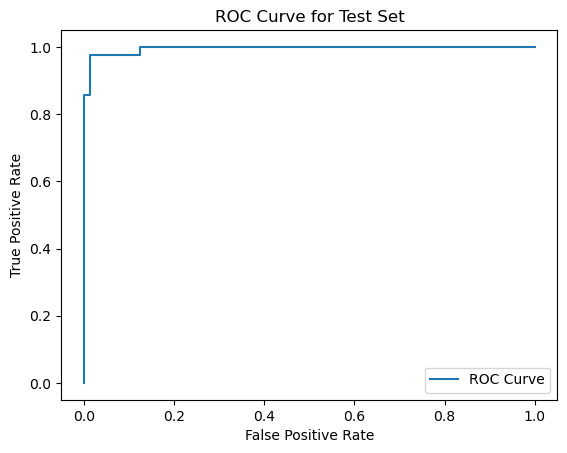

Training Confusion Matrix:
[[285   0]
 [  8 162]]

Test Confusion Matrix:
[[72  0]
 [ 6 36]]


In [23]:
M = 30 
param_grid = {'C': np.logspace(-4, 4, 10)}
results = {
    "train_accuracy": [], "test_accuracy": [],
    "train_precision": [], "test_precision": [],
    "train_recall": [], "test_recall": [],
    "train_f1": [], "test_f1": [],
    "train_auc": [], "test_auc": []
}
for _ in range(M):
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, stratify=y, random_state=42)
    svc = LinearSVC(penalty='l1', dual=False, max_iter=10000)
    grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_svc = grid.best_estimator_
    clf = CalibratedClassifierCV(best_svc)  # For probability estimates
    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_prob_train = clf.predict_proba(X_train)[:, 1]
    y_prob_test = clf.predict_proba(X_test)[:, 1]

    results["train_accuracy"].append(accuracy_score(y_train, y_pred_train))
    results["test_accuracy"].append(accuracy_score(y_test, y_pred_test))
    results["train_precision"].append(precision_score(y_train, y_pred_train))
    results["test_precision"].append(precision_score(y_test, y_pred_test))
    results["train_recall"].append(recall_score(y_train, y_pred_train))
    results["test_recall"].append(recall_score(y_test, y_pred_test))
    results["train_f1"].append(f1_score(y_train, y_pred_train))
    results["test_f1"].append(f1_score(y_test, y_pred_test))
    results["train_auc"].append(roc_auc_score(y_train, y_prob_train))
    results["test_auc"].append(roc_auc_score(y_test, y_prob_test))

avg_metrics = {metric: np.mean(values) for metric, values in results.items()}
print("Average Metrics over 30 runs:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Test Set")
plt.legend()
plt.show()
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Training Confusion Matrix:")
print(conf_matrix_train)
print("\nTest Confusion Matrix:")
print(conf_matrix_test)
    


#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

In [26]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_normalized, y, test_size=0.2, stratify=y, random_state=42
)

positive_indices = np.where(y_train_full == 1)[0]
negative_indices = np.where(y_train_full == 0)[0]
np.random.shuffle(positive_indices)
np.random.shuffle(negative_indices)

# Use 50% of each class as labeled
labeled_pos = positive_indices[:len(positive_indices) // 2]
labeled_neg = negative_indices[:len(negative_indices) // 2]
labeled_indices = np.concatenate((labeled_pos, labeled_neg))

X_labeled = X_train_full[labeled_indices]
y_labeled = y_train_full[labeled_indices]

# Train an L1-penalized SVM on labeled data
param_grid = {'C': np.logspace(-4, 4, 10)}  # Penalty parameter range
svc = LinearSVC(penalty='l1', dual=False, max_iter=10000)
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid.fit(X_labeled, y_labeled)

# Get the best model
best_svc = grid.best_estimator_
best_svc.fit(X_labeled, y_labeled)

LinearSVC(C=np.float64(0.046415888336127774), dual=False, max_iter=10000,
          penalty='l1')

##### (B)

In [28]:
unlabeled_indices = np.setdiff1d(np.arange(len(y_train_full)), labeled_indices)
X_unlabeled = X_train_full[unlabeled_indices]
clf = CalibratedClassifierCV(best_svc)
clf.fit(X_labeled, y_labeled)

while len(X_unlabeled) > 0:
    distances = best_svc.decision_function(X_unlabeled)
    farthest_idx = np.argmax(np.abs(distances))
    
    X_new = X_unlabeled[farthest_idx].reshape(1, -1)
    y_new = clf.predict(X_new)
    X_labeled = np.vstack([X_labeled, X_new])
    y_labeled = np.append(y_labeled, y_new)
    
    X_unlabeled = np.delete(X_unlabeled, farthest_idx, axis=0)
    best_svc.fit(X_labeled, y_labeled)
    clf = CalibratedClassifierCV(best_svc)
    clf.fit(X_labeled, y_labeled)

y_pred_train = clf.predict(X_labeled)
y_pred_test = clf.predict(X_test)
y_prob_test = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_prob_test)
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final Test Precision: {precision:.4f}")
print(f"Final Test Recall: {recall:.4f}")
print(f"Final Test F1-Score: {f1:.4f}")
print(f"Final Test AUC: {auc:.4f}")

Final Test Accuracy: 0.9561
Final Test Precision: 1.0000
Final Test Recall: 0.8810
Final Test F1-Score: 0.9367
Final Test AUC: 0.9977


#### (iii) Unsupervised Learning

##### (A)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, stratify=y, random_state=42)

n_init = 10 
kmeans = KMeans(n_clusters=2, n_init=n_init, random_state=42)
kmeans.fit(X_train)

# Print inertia to check for convergence
print(f"Inertia (sum of squared distances to nearest cluster center): {kmeans.inertia_}")

Inertia (sum of squared distances to nearest cluster center): 9478.031887624176


##### (B)

In [34]:
centers = kmeans.cluster_centers_
distances = cdist(X_train, centers)
closest_points_idx = np.argsort(distances, axis=0)[:30, :]  # Closest 30 points to each center

cluster_labels = []
for i in range(2): 
    labels = y_train[closest_points_idx[:, i]]
    majority_label = np.argmax(np.bincount(labels))
    cluster_labels.append(majority_label)

y_train_pred_clusters = np.array([cluster_labels[label] for label in kmeans.labels_])

train_accuracy = accuracy_score(y_train, y_train_pred_clusters)
train_precision = precision_score(y_train, y_train_pred_clusters)
train_recall = recall_score(y_train, y_train_pred_clusters)
train_f1 = f1_score(y_train, y_train_pred_clusters)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")

Training Accuracy: 0.9121
Training Precision: 0.9221
Training Recall: 0.8353
Training F1-Score: 0.8765


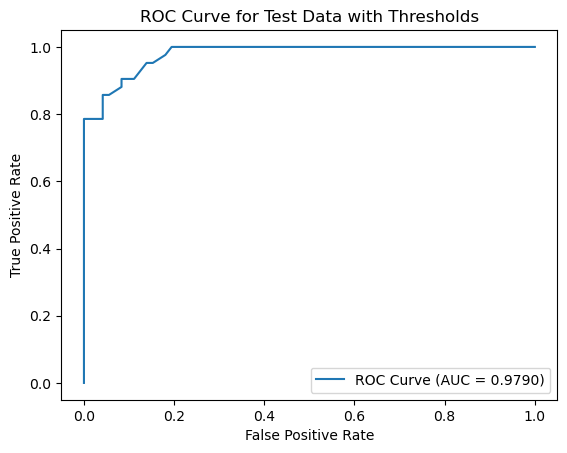

Confusion Matrix at Threshold 0.5:
[[70  2]
 [ 9 33]]


In [39]:
test_distances = cdist(X_test, centers)
softmax_probs = softmax(-test_distances, axis=1) 

def compute_metrics_at_threshold(threshold):
    predicted_clusters = (softmax_probs[:, 1] >= threshold).astype(int)
    y_test_pred = np.array([cluster_labels[cluster] for cluster in predicted_clusters])

    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    return y_test_pred, acc, prec, rec, f1

thresholds = np.linspace(0, 1, 100)
tprs, fprs, metrics = [], [], []

for t in thresholds:
    y_test_pred, acc, prec, rec, f1 = compute_metrics_at_threshold(t)
    metrics.append((acc, prec, rec, f1))
    
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    tpr = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])  # TP / (TP + FN)
    fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])  # FP / (FP + TN)
    tprs.append(tpr)
    fprs.append(fpr)

roc_auc = auc(fprs, tprs)

plt.figure()
plt.plot(fprs, tprs, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Test Data with Thresholds")
plt.legend()
plt.show()
final_threshold = 0.5
y_test_pred, _, _, _, _ = compute_metrics_at_threshold(final_threshold)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix at Threshold 0.5:")
print(conf_matrix_test)

#### (iv) Spectral Clustering

Cluster sizes: Cluster 0 = 453, Cluster 1 = 2
Training Accuracy: 0.6308
Training Precision: 1.0000
Training Recall: 0.0118
Training F1-Score: 0.0233
Test Accuracy: 0.2368
Test Precision: 0.2727
Test Recall: 0.6429
Test F1-Score: 0.3830
Test AUC: 0.3214


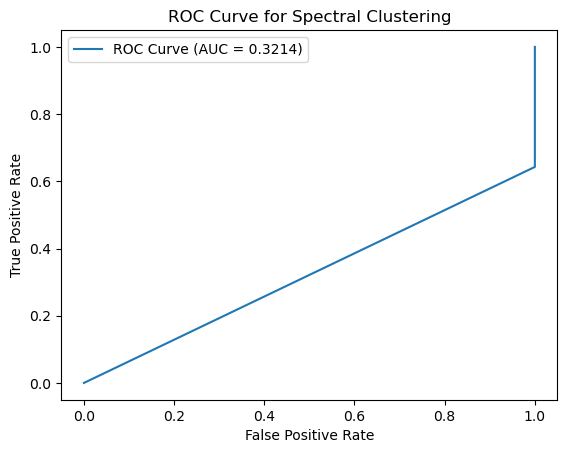

Test Confusion Matrix:
[[ 0 72]
 [15 27]]


In [43]:
gamma = 1  
spectral = SpectralClustering(n_clusters=2, affinity='rbf', gamma=gamma, random_state=42)
cluster_labels = spectral.fit_predict(X_train)

cluster_0_size = np.sum(cluster_labels == 0)
cluster_1_size = np.sum(cluster_labels == 1)
print(f"Cluster sizes: Cluster 0 = {cluster_0_size}, Cluster 1 = {cluster_1_size}")
cluster_0_indices = np.where(cluster_labels == 0)[0]
cluster_1_indices = np.where(cluster_labels == 1)[0]
np.random.shuffle(cluster_0_indices)
np.random.shuffle(cluster_1_indices)

cluster_0_labels = y_train[cluster_0_indices[:30]]
cluster_1_labels = y_train[cluster_1_indices[:30]]
cluster_0_majority = mode(cluster_0_labels, axis=None).mode
cluster_1_majority = mode(cluster_1_labels, axis=None).mode
cluster_0_majority = cluster_0_majority[0] if isinstance(cluster_0_majority, np.ndarray) else cluster_0_majority
cluster_1_majority = cluster_1_majority[0] if isinstance(cluster_1_majority, np.ndarray) else cluster_1_majority

cluster_to_class = {0: cluster_0_majority, 1: cluster_1_majority}
y_train_pred = np.array([cluster_to_class[label] for label in cluster_labels])

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")

test_distances = spectral.affinity_matrix_
y_test_pred_clusters = spectral.fit_predict(X_test)
y_test_pred = np.array([cluster_to_class[label] for label in y_test_pred_clusters])

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

test_auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Spectral Clustering")
plt.legend()
plt.show()

conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(conf_matrix_test)

#### (iv) Compare

Supervised:
Average Metrics over 30 runs:
train_accuracy: 0.9824
test_accuracy: 0.9474
train_precision: 1.0000
test_precision: 1.0000
train_recall: 0.9529
test_recall: 0.8571
train_f1: 0.9759
test_f1: 0.9231
train_auc: 0.9978
test_auc: 0.9954

Semi-Supervised:
Final Test Accuracy: 0.9561
Final Test Precision: 1.0000
Final Test Recall: 0.8810
Final Test F1-Score: 0.9367
Final Test AUC: 0.9977

Unsupervised:
Training Accuracy: 0.9121
Training Precision: 0.9221
Training Recall: 0.8353
Training F1-Score: 0.8765

Spectral:
Cluster sizes: Cluster 0 = 453, Cluster 1 = 2
Training Accuracy: 0.6308
Training Precision: 1.0000
Training Recall: 0.0118
Training F1-Score: 0.0233
Test Accuracy: 0.2368
Test Precision: 0.2727
Test Recall: 0.6429
Test F1-Score: 0.3830
Test AUC: 0.3214

## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [51]:
header = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
data = pd.read_csv('../data/data_banknote_authentication.txt', names=header)

In [ ]:
X = data.iloc[:, :-1].values 
y = data.iloc[:, -1].values  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=472, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

In [ ]:
n_runs = 50  
pool_increment = 10  
train_size = 900  
param_grid = {'C': np.logspace(-3, 6, 20)} 

all_passive_errors = []

for run in range(n_runs):
    print(f"Passive Learning - Run {run + 1}/{n_runs}")

    shuffled_indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    pool_indices = np.arange(pool_increment)
    test_errors = []

    while len(pool_indices) <= train_size:
        X_pool = X_train_shuffled[pool_indices]
        y_pool = y_train_shuffled[pool_indices]
        svc = LinearSVC(penalty='l1', dual=False, max_iter=10000)
        grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_pool, y_pool)

        best_svm = grid_search.best_estimator_

        y_test_pred = best_svm.predict(X_test)
        test_error = 1 - accuracy_score(y_test, y_test_pred)
        test_errors.append(test_error)

        pool_indices = np.arange(len(pool_indices) + pool_increment)

    all_passive_errors.append(test_errors)

mean_passive_errors = np.mean(all_passive_errors, axis=0)

Passive Learning - Run 1/50
Passive Learning - Run 2/50
Passive Learning - Run 3/50
Passive Learning - Run 4/50
Passive Learning - Run 5/50
Passive Learning - Run 6/50
Passive Learning - Run 7/50
Passive Learning - Run 8/50
Passive Learning - Run 9/50
Passive Learning - Run 10/50
Passive Learning - Run 11/50
Passive Learning - Run 12/50
Passive Learning - Run 13/50
Passive Learning - Run 14/50
Passive Learning - Run 15/50
Passive Learning - Run 16/50
Passive Learning - Run 17/50
Passive Learning - Run 18/50
Passive Learning - Run 19/50
Passive Learning - Run 20/50
Passive Learning - Run 21/50
Passive Learning - Run 22/50
Passive Learning - Run 23/50
Passive Learning - Run 24/50
Passive Learning - Run 25/50
Passive Learning - Run 26/50
Passive Learning - Run 27/50
Passive Learning - Run 28/50
Passive Learning - Run 29/50
Passive Learning - Run 30/50
Passive Learning - Run 31/50
Passive Learning - Run 32/50
Passive Learning - Run 33/50
Passive Learning - Run 34/50
Passive Learning - Run 

#### (ii) Active

In [ ]:
all_active_errors = []

for run in range(n_runs):
    print(f"Active Learning - Run {run + 1}/{n_runs}")
    shuffled_indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    while True:
        pool_indices = np.random.choice(train_size, pool_increment, replace=False)
        if len(np.unique(y_train_shuffled[pool_indices])) > 1:
            break

    remaining_indices = np.setdiff1d(np.arange(train_size), pool_indices)
    test_errors = []

    while len(pool_indices) <= train_size:
        X_pool = X_train_shuffled[pool_indices]
        y_pool = y_train_shuffled[pool_indices]
        svc = LinearSVC(penalty='l1', dual=False, max_iter=10000)
        grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_pool, y_pool)
        best_svm = grid_search.best_estimator_
        y_test_pred = best_svm.predict(X_test)
        test_error = 1 - accuracy_score(y_test, y_test_pred)
        test_errors.append(test_error)

        if len(pool_indices) >= train_size:
            break

        distances = np.abs(best_svm.decision_function(X_train_shuffled[remaining_indices]))
        closest_indices = np.argsort(distances)[:pool_increment]
        new_indices = remaining_indices[closest_indices]
        pool_indices = np.concatenate([pool_indices, new_indices])
        remaining_indices = np.setdiff1d(remaining_indices, new_indices)

    all_active_errors.append(test_errors)

mean_active_errors = np.mean(all_active_errors, axis=0)

Active Learning - Run 1/50
Active Learning - Run 2/50
Active Learning - Run 3/50
Active Learning - Run 4/50
Active Learning - Run 5/50
Active Learning - Run 6/50
Active Learning - Run 7/50
Active Learning - Run 8/50
Active Learning - Run 9/50
Active Learning - Run 10/50
Active Learning - Run 11/50
Active Learning - Run 12/50
Active Learning - Run 13/50
Active Learning - Run 14/50
Active Learning - Run 15/50
Active Learning - Run 16/50
Active Learning - Run 17/50
Active Learning - Run 18/50
Active Learning - Run 19/50
Active Learning - Run 20/50
Active Learning - Run 21/50
Active Learning - Run 22/50
Active Learning - Run 23/50
Active Learning - Run 24/50
Active Learning - Run 25/50
Active Learning - Run 26/50
Active Learning - Run 27/50
Active Learning - Run 28/50
Active Learning - Run 29/50
Active Learning - Run 30/50
Active Learning - Run 31/50
Active Learning - Run 32/50
Active Learning - Run 33/50
Active Learning - Run 34/50
Active Learning - Run 35/50
Active Learning - Run 36/50
A

### (c) Average the 50 test errors

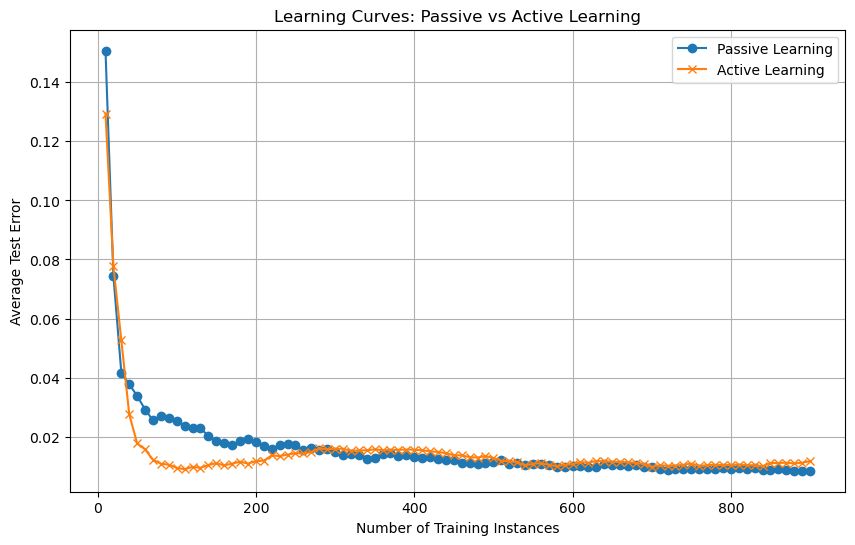

In [ ]:
x = np.arange(pool_increment, train_size + 1, pool_increment)
plt.figure(figsize=(10, 6))
plt.plot(x, mean_passive_errors, marker='o', label='Passive Learning')
plt.plot(x, mean_active_errors, marker='x', label='Active Learning')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.title('Learning Curves: Passive vs Active Learning')
plt.legend()
plt.grid()
plt.show()